## Notebook for Running Experiments on CovType Data Set

In [1]:
from typing import List
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import nannyml as nml
from test_harness.datasets.dataset import Dataset

from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

In [3]:
from  test_harness.experiments.dde_experiment import DDEffectExperiment
from test_harness.experiments.baseline_experiment import BaselineExperiment

## Load Data

#### Heartbeats dataset

500 train originally

In [4]:
full_df = pd.read_csv("../data/heartbeats_full.data", header=None)#.rename(columns={'period': 'period_original'})
full_df.columns = [f'feat_{c+1}' for c in full_df.columns]

In [5]:
full_df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_272,feat_273,feat_274,feat_275,feat_276,feat_277,feat_278,feat_279,feat_280,feat_281
0,-0.583660,-1.19050,-1.06650,-1.00280,-0.96759,-1.09060,-1.43060,-1.50040,-1.81840,-1.037700,...,-2.768900,-2.443700,-2.499100,-2.534600,-2.519600,-2.257900,-2.266700,-2.138000,-2.394400,8
1,-0.472420,-0.49045,-0.50777,-0.52436,-0.54024,-0.55541,-0.56987,-0.58362,-0.59666,-0.609010,...,2.617000,2.650600,2.683700,2.716100,2.748000,2.779200,2.809900,2.839800,2.869200,8
2,-0.841230,-0.99355,-0.60240,-0.88060,-0.83972,-0.89159,-1.20550,-1.20930,-0.82451,-0.082188,...,-0.292010,-0.299460,-0.300060,-0.228640,-0.308050,-0.221880,-0.129280,-0.457620,0.218760,1
3,-0.784450,-0.91108,-0.63747,-0.80738,-0.78744,-0.87697,-1.10290,-1.11380,-0.77736,0.009708,...,-0.100310,-0.091361,-0.107160,-0.053507,-0.094967,-0.074152,-0.001559,-0.184430,0.164560,1
4,-0.803560,-0.88539,-0.76955,-1.01080,-1.21240,-1.30290,-0.94300,-0.07803,0.71332,1.142900,...,-0.305020,-0.303850,-0.308990,-0.284710,-0.312510,-0.288680,-0.244850,-0.360740,-0.180830,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77899,0.631060,0.74096,0.84225,1.13200,1.44300,1.93090,2.58450,3.30950,4.09030,4.752300,...,0.070819,0.068431,0.061483,0.064957,0.072900,0.090139,0.097796,0.119520,0.161570,3
77900,0.059665,0.16575,0.35738,0.62163,0.99412,1.53410,2.19410,2.94730,3.71320,4.246600,...,0.572050,0.573180,0.553140,0.594890,0.577380,0.640070,0.583920,0.701510,0.678370,3
77901,0.478810,0.67104,0.83665,1.22040,1.58990,2.20450,2.96800,3.74530,4.45670,4.953200,...,-0.035709,-0.046083,-0.042969,-0.028890,-0.036115,0.004972,-0.021184,0.047317,0.057406,3
77902,0.584420,0.71022,0.90344,1.19610,1.62550,2.19560,2.82180,3.61170,4.29180,4.760900,...,0.125240,0.135670,0.131170,0.136890,0.141620,0.143550,0.162590,0.187010,0.249300,3


<AxesSubplot:>

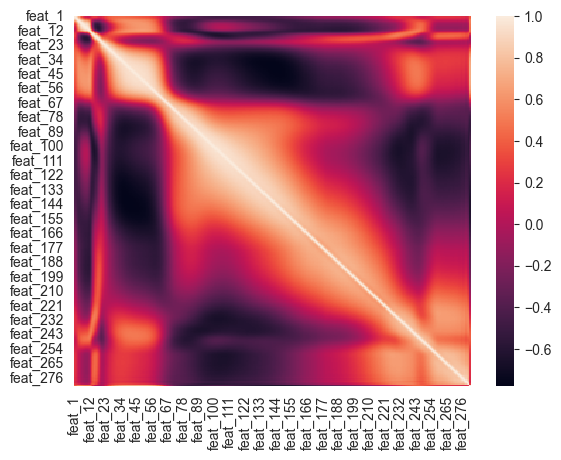

In [6]:
sns.heatmap(full_df.corr())

In [5]:
full_df['class'] = np.where(full_df['class']=='UP', 1, 0)

In [6]:
full_df

,date,day,period_original,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0000,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0000,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0000,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0000,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0000,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0
...,...,...,...,...,...,...,...,...,...
45307,0.9158,7,0.914894,0.044224,0.340672,0.003033,0.255049,0.405263,0
45308,0.9158,7,0.936170,0.044884,0.355549,0.003072,0.241326,0.420614,0
45309,0.9158,7,0.957447,0.043593,0.340970,0.002983,0.247799,0.362281,0
45310,0.9158,7,0.978723,0.066651,0.329366,0.004630,0.345417,0.206579,1


In [7]:
cat_features = []

In [8]:
numeric_features = full_df.columns

In [9]:
# model_cicids = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
# param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

              precision    recall  f1-score   support

           0       0.86      0.61      0.71      4974
           1       0.65      0.88      0.74      4089

    accuracy                           0.73      9063
   macro avg       0.75      0.74      0.73      9063
weighted avg       0.76      0.73      0.73      9063

Accuracy: 0.7279046673286991


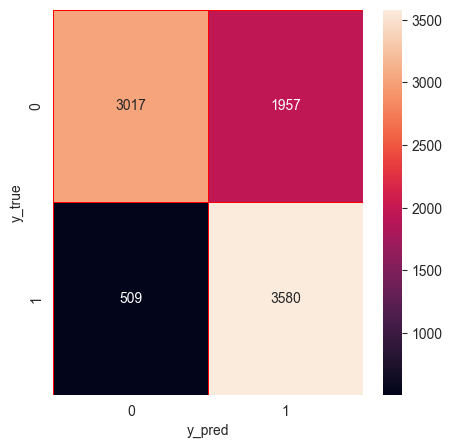

In [10]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = full_df.drop(['class'],axis=1)
y = full_df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, shuffle=False,random_state = 0)

# # LightGBM algorithm
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [11]:
top_feats_df = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns.tolist()}).sort_values(by="Value",ascending=False)

In [12]:
top_feats = top_feats_df[top_feats_df['Value']>10].Feature.tolist()

In [13]:
full_df_reduced = full_df[top_feats]

In [14]:
column_mapping_adult = {
    "target": "class",
    "numerical_features": full_df_reduced.columns,
    "categorical_features": [],
}

In [15]:
CT_dataset = Dataset(
    full_df=full_df_reduced, column_mapping=column_mapping_adult, window_size=1500 * 2, reference_size=1000
)

D:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.reference_df['period'] = 'reference'
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.reference_df['sample_num'] = self.reference_df.index
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [16]:
# plt.figure(figsize=(12,10))
# sns.heatmap(CT_dataset.full_df.corr(), annot=True)
#
# plt.title('Dataset correlation map')
# plt.show()

## Run Experiments

In [17]:
def windowed_correlation(df, mode='expanding'):
    corr_dict = {}
    columns = df.columns
    n = len(columns)
    for i in range(n):
        for j in range(i+1, n):
            col1 = columns[i]
            col2 = columns[j]
            key = (col1, col2)

            if mode=='expanding':
                corr_dict[key] = df[col1].expanding(10).corr(df[col2])
            else:
                corr_dict[key] = df[col1].rolling(window=10).corr(df[col2])

            corr_dict[key] = corr_dict[key].fillna(0)

    return corr_dict

In [18]:
def plot_windowed_correlation(corr_dict, vertical_lines=None):
    plt.figure(figsize=(15,10))
    for (col1, col2), corr in corr_dict.items():
        plt.plot(corr, label=f"{col1} vs {col2}")

    if vertical_lines:
        [plt.axvline(x, color='gray', linestyle='--') for x in vertical_lines if x != 0]

    plt.legend(bbox_to_anchor=(1, 0.5))
    labelLines(plt.gca().get_lines(), align=True)
    plt.show()

In [19]:
corr_dict = windowed_correlation(CT_dataset.full_df.loc[:, CT_dataset.full_df.columns], mode='expanding')

D:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\labellines\core.py:67: UserWarning: Line2D(date vs vicdemand) could not be annotated due to `nans` values. Consider using another location via the `x` argument.
  warnings.warn(
D:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\labellines\core.py:67: UserWarning: Line2D(date vs vicprice) could not be annotated due to `nans` values. Consider using another location via the `x` argument.
  warnings.warn(
D:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\labellines\core.py:67: UserWarning: Line2D(nswprice vs vicdemand) could not be annotated due to `nans` values. Consider using another location via the `x` argument.
  warnings.warn(


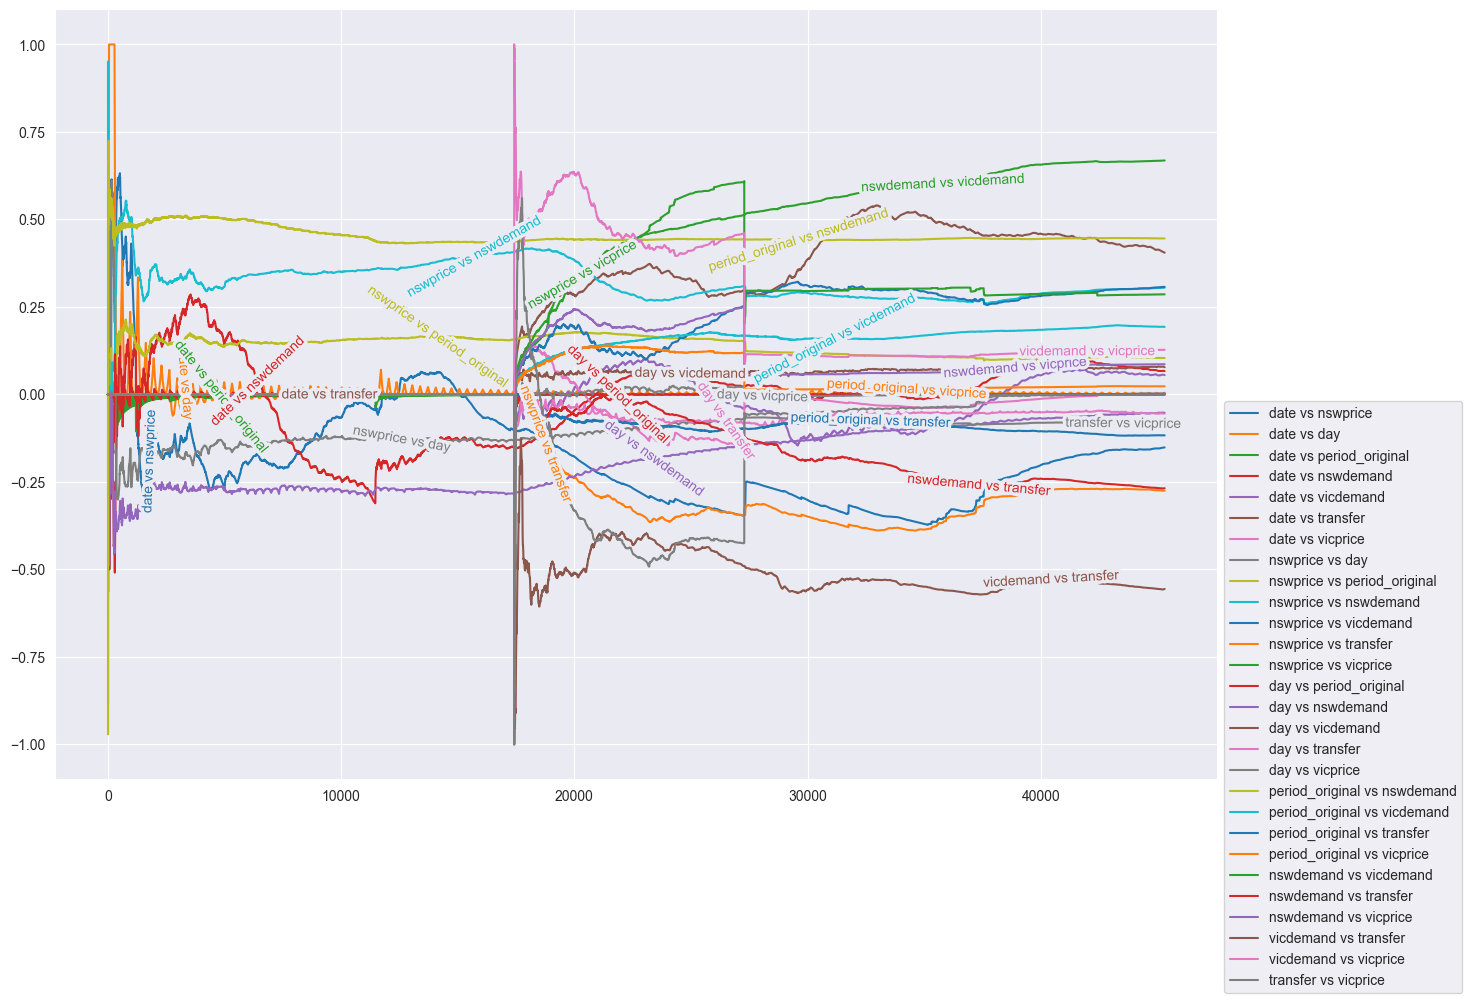

In [20]:
plot_windowed_correlation(corr_dict)

In [21]:
column_names = list(CT_dataset.reference_df.columns)

In [22]:
calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    #timestamp_column_name='sample_num',
    continuous_methods=['jensen_shannon'],
    categorical_methods=['jensen_shannon'],
    #chunk_number=10,
    chunk_size=500,
)

calc.fit(CT_dataset.reference_df)

D:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\nannyml\chunk.py:181: UserWarning: The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.
  warnings.warn(


In [23]:
results = calc.calculate(CT_dataset.analysis_df)

In [24]:
results_js = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).to_df()
results_js.columns = ['_'.join(col) for col in results_js.columns.values]
display(results_js)

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,date_jensen_shannon_value,date_jensen_shannon_upper_threshold,date_jensen_shannon_lower_threshold,...,transfer_jensen_shannon_lower_threshold,transfer_jensen_shannon_alert,vicprice_jensen_shannon_value,vicprice_jensen_shannon_upper_threshold,vicprice_jensen_shannon_lower_threshold,vicprice_jensen_shannon_alert,sample_num_jensen_shannon_value,sample_num_jensen_shannon_upper_threshold,sample_num_jensen_shannon_lower_threshold,sample_num_jensen_shannon_alert
0,[0:499],0,0,499,None,None,analysis,0.987726,0.1,None,...,None,False,0.0,0.1,None,False,0.996512,0.1,None,True
1,[500:999],1,500,999,None,None,analysis,1.000000,0.1,None,...,None,False,0.0,0.1,None,False,1.000000,0.1,None,True
2,[1000:1499],2,1000,1499,None,None,analysis,1.000000,0.1,None,...,None,False,0.0,0.1,None,False,1.000000,0.1,None,True
3,[1500:1999],3,1500,1999,None,None,analysis,1.000000,0.1,None,...,None,False,0.0,0.1,None,False,1.000000,0.1,None,True
4,[2000:2499],4,2000,2499,None,None,analysis,1.000000,0.1,None,...,None,False,0.0,0.1,None,False,1.000000,0.1,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,[41500:41999],83,41500,41999,None,None,analysis,1.000000,0.1,None,...,None,True,1.0,0.1,None,True,1.000000,0.1,None,True
84,[42000:42499],84,42000,42499,None,None,analysis,1.000000,0.1,None,...,None,True,1.0,0.1,None,True,1.000000,0.1,None,True
85,[42500:42999],85,42500,42999,None,None,analysis,1.000000,0.1,None,...,None,True,1.0,0.1,None,True,1.000000,0.1,None,True
86,[43000:43499],86,43000,43499,None,None,analysis,1.000000,0.1,None,...,None,True,1.0,0.1,None,True,1.000000,0.1,None,True


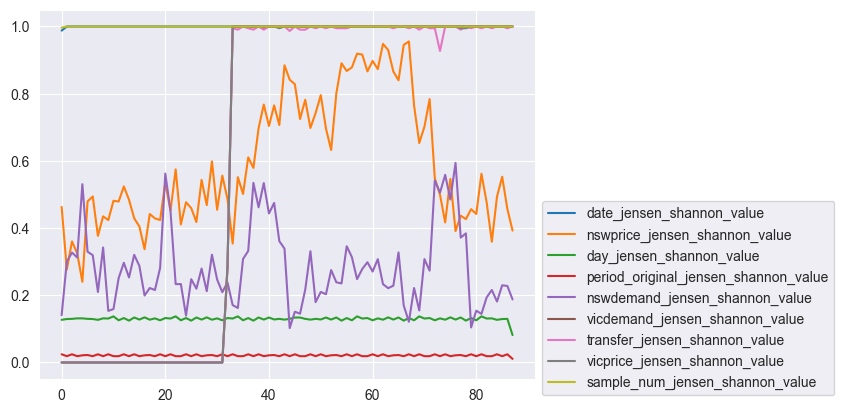

In [25]:
results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]].plot()
plt.legend(bbox_to_anchor=(1, 0.5))

In [26]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
# figure.show()

In [27]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

### Own Jensen-Shannon

In [28]:
chg_points = [17500]

In [29]:
CT_dataset.add_changepoints(chg_points)

In [30]:
rad_left = 500
rad_right = 500

In [31]:
dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=rad_left, radius_right=rad_right)
display(dde_exp_eq_radius.results_all)

17000 17500 18000


D:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['period'] = 'reference'
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['sample_num'] = ref_df.index
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,start,change_point,end,date,nswprice,day,period_original,nswdemand,vicdemand,transfer,vicprice,sample_num
0,17000,17500,18000,0.975856,0.349198,0.259261,0.037037,0.388698,0.784611,0.853421,0.724905,0.996436


In [32]:
dde_exp_eq_radius.changepoint_radius_corr(radius_left=rad_left, radius_right=rad_right)

17000 17500 18000


#### Change point 1

In [33]:
with pd.ExcelWriter(f'outputs/elec/CD_delta_vs_ro_chp_tabs.xlsx') as writer:

    for chp in CT_dataset.change_points:
        drift_threshold = 0.3
        summary_df = pd.DataFrame(columns=['feat_1', 'feat_2', 'ref_corr', 'analysis_corr', 'corr_delta', 'feat_1_cd_score', 'feat_2_cd_score', 'delta_cd_score'])

        corr_df_delta = dde_exp_eq_radius.corr_scores[chp]['corr_delta']
        corr_df_analysis = dde_exp_eq_radius.corr_scores[chp]['analysis']
        corr_df_ref = dde_exp_eq_radius.corr_scores[chp]['reference']

        cd_score_df = dde_exp_eq_radius.results_all.loc[dde_exp_eq_radius.results_all['change_point']==chp].iloc[0]

        for pair in itertools.combinations(dde_exp_eq_radius.dataset.full_df.columns, 2):
            feat1 = list(pair)[0]
            feat2 = list(pair)[1]

            summary_df.loc[len(summary_df.index)] = [feat1, feat2, np.abs(corr_df_ref.loc[feat1, feat2]), np.abs(corr_df_analysis.loc[feat1, feat2]), corr_df_delta.loc[feat1, feat2], cd_score_df[feat1], cd_score_df[feat2], np.abs(cd_score_df[feat1]-cd_score_df[feat2])]

        summary_df['feat_1_drift'] = np.where(summary_df['feat_1_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_2_drift'] = np.where(summary_df['feat_2_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_pair_drift'] = np.where(summary_df['feat_1_drift'] & summary_df['feat_2_drift'], 1, 0)

        summary_df.to_excel(writer, sheet_name=f'{chp}', index=False)

In [34]:
summary_df = summary_df.sort_values(by=['corr_delta'], ascending=False)

In [35]:
summary_df

,feat_1,feat_2,ref_corr,analysis_corr,corr_delta,feat_1_cd_score,feat_2_cd_score,delta_cd_score,feat_1_drift,feat_2_drift,feat_pair_drift
12,nswprice,vicprice,0.204827,0.987257,0.782430,0.349198,0.724905,0.375708,1,1,1
5,date,transfer,0.410817,0.108684,0.519501,0.975856,0.853421,0.122435,1,1,1
22,nswdemand,vicdemand,0.345231,0.831601,0.486370,0.388698,0.784611,0.395913,1,1,1
10,nswprice,vicdemand,0.176322,0.588620,0.412298,0.349198,0.784611,0.435413,1,1,1
23,nswdemand,transfer,0.144947,0.539314,0.394366,0.388698,0.853421,0.464723,1,1,1
24,nswdemand,vicprice,0.352710,0.723304,0.370594,0.388698,0.724905,0.336207,1,1,1
16,day,transfer,0.510576,0.144594,0.365982,0.259261,0.853421,0.594160,0,1,0
0,date,nswprice,0.191403,0.156602,0.348005,0.975856,0.349198,0.626658,1,1,1
21,period_original,vicprice,0.150039,0.450784,0.300745,0.037037,0.724905,0.687868,0,1,0
4,date,vicdemand,0.304790,0.011581,0.293209,0.975856,0.784611,0.191245,1,1,1


In [36]:
def get_roc_auc(scores, ys):
    # false positive rate
    FPR = []
    # true positive rate
    TPR = []
    # Iterate thresholds from 0.0 to 1.0
    thresholds = np.arange(0.0, 1.01, 0.2)
    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

    # get number of positive and negative examples in the dataset
    P = sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for thresh in thresholds:
        FP=0
        TP=0
        thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
        for i in range(len(score)):
            if (score[i] >= thresh):
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP/N)
        TPR.append(TP/P)

    auc = -1 * np.trapz(TPR, FPR)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%auc)
    plt.legend(loc="lower right")
    plt.savefig('AUC_example.png')
    plt.show()

In [37]:
def plot_lift_curve(y_pred, y_val, step=0.01):

    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)

    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []

    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)

   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

In [38]:
score = summary_df.ref_corr #np.array([0.8, 0.6, 0.4, 0.2])
y = summary_df.feat_pair_drift #np.array([1,0,1,0])

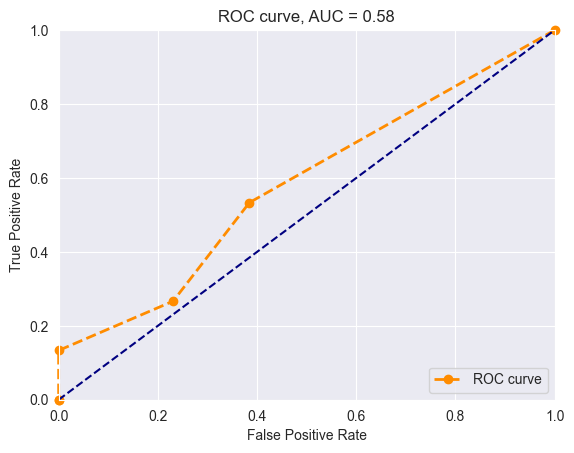

In [39]:
get_roc_auc(score, y)

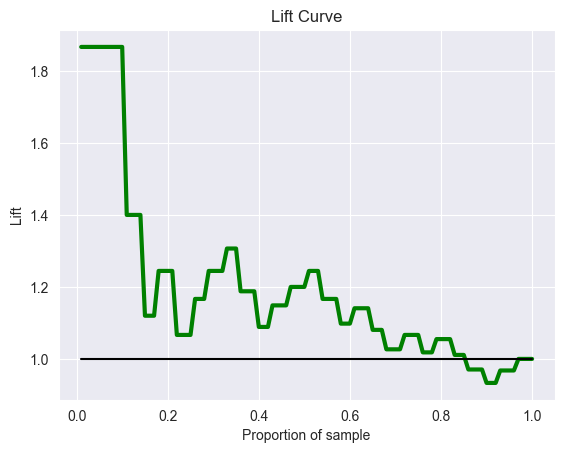

In [40]:
plot_lift_curve(score, y)